In [213]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import optimizers

# for logging
from keras.callbacks import CSVLogger

In [214]:
df = pd.read_csv('datasets/ge.us.txt', sep=',')

In [215]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [216]:
df.shape

(14058, 7)

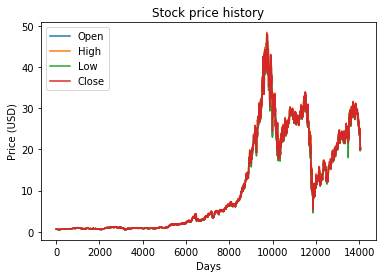

In [217]:
plt.figure()

plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])

plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.title('Stock price history')

plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show();

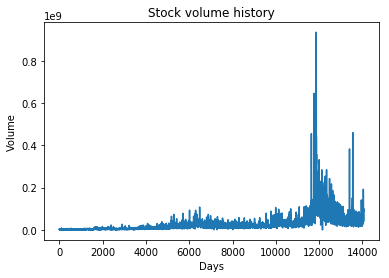

In [218]:
plt.figure()

plt.plot(df["Volume"])
plt.title('Stock volume history')

plt.xlabel('Days')
plt.ylabel('Volume')

plt.show();

In [219]:
print("null values: \n", df.isna().sum())

null values: 
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [220]:
print("missing values: \n", df.isnull().sum())

missing values: 
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [ ]:
#checking hidden missing values
print(len(df[df['Open'] == 0]))
print(len(df[df['High'] == 0]))
print(len(df[df['Low'] == 0]))
print(len(df[df['Close'] == 0]))
print(len(df[df['Volume'] == 0]))

0
0
0
0
1


In [ ]:
df[df['Volume'] == 0]

,Date,Open,High,Low,Close,Volume,OpenInt
12155,2010-04-26,15.459,15.594,15.377,15.54,0,0


In [ ]:
train_cols = ["Open","High","Low","Close","Volume"]

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print("train size: {}% ---- test size: {}% ".format(round(len(df_train) / df.shape[0],2)*100, 
                                                    round(len(df_test) / df.shape[0],2)*100))

train size: 80.0% ---- test size: 20.0% 


In [ ]:
x = df_train.loc[:,train_cols].values

In [ ]:
# scaling the values in the dataset
min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [ ]:
x_train.shape

(11246, 5)

In [ ]:
x_test.shape

(2812, 5)

In [ ]:
pd.DataFrame(x_test).describe()

,0,1,2,3,4
count,2812.000000,2812.000000,2812.000000,2812.000000,2812.000000
mean,0.210113,0.209070,0.208530,0.208657,0.024875
std,0.247039,0.245969,0.245010,0.245341,0.035288
min,0.000844,0.000667,0.000680,0.000508,-0.000294
25%,0.009194,0.009056,0.009220,0.009135,0.005496
50%,0.072521,0.072136,0.072314,0.072477,0.016595
75%,0.432113,0.430260,0.428580,0.427495,0.029363
max,0.993720,0.992624,0.990476,0.997815,0.492165


#### The LSTM input layer must be 3D. The three dimensions of the input are:

<b>Samples: </b> One sequence is one sample. A batch is comprised of one or more samples. </br>
<b>Time Steps: </b> One time step is one point of observation in the sample. </br>
<b>Features: </b> One feature is one observation at a time step. </br>

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires that you specify the number of time steps and the number of features. You can do this by specifying a tuple to the “input_shape” argument.




In [ ]:
def build_timeseries(mat, y_col_index):
    
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    
    # ???
    TIME_STEPS = 4
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in (range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o", x.shape,y.shape)
    return x, y

In [ ]:
def trim_dataset(mat, batch_size):
    
    no_of_rows_drop = mat.shape[0]%batch_size
    
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [ ]:
x_t, y_t = build_timeseries(x_train, 3)

# ???
BATCH_SIZE = 1

x_t = trim_dataset(x_t, BATCH_SIZE)

y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)

x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)

y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11242, 4, 5) (11242,)
length of time-series i/o (2808, 4, 5) (2808,)


In [ ]:
BATCH_SIZE = 1
TIME_STEPS = 4

lr = 0.001

lstm_model = Sequential()
lstm_model.add(LSTM(50, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), 
                    dropout=0.0, recurrent_dropout=0.0, 
                    stateful=True,
                    kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(10,activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1,activation='linear'))

optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [ ]:
OUTPUT_PATH = 'datasets/'

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=10, verbose=2, batch_size=BATCH_SIZE,
                         shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                         trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 11242 samples, validate on 1404 samples
Epoch 1/10
 - 36s - loss: 0.0643 - val_loss: 0.0625
Epoch 2/10
 - 37s - loss: 0.0654 - val_loss: 0.0619
Epoch 3/10
 - 35s - loss: 0.0655 - val_loss: 0.0658
Epoch 4/10
 - 35s - loss: 0.0653 - val_loss: 0.0620
Epoch 5/10
 - 34s - loss: 0.0639 - val_loss: 0.0620
Epoch 6/10
 - 35s - loss: 0.0629 - val_loss: 0.0622
Epoch 7/10
 - 37s - loss: 0.0629 - val_loss: 0.0625
Epoch 8/10
 - 35s - loss: 0.0629 - val_loss: 0.0620
Epoch 9/10
